# Import Library

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Download and Extract Dataset

In [2]:
base_dir = 'image-model-2/'


In [3]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
folders = glob('image-model-2/*')

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [7]:
os.listdir(base_dir)

['bopeng', 'jerawat', 'normal']

In [8]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)


In [9]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()


tag
bopeng     476
jerawat    480
normal     480
dtype: int64

In [10]:
df.head(10)

,path,file_name,tag
0,image-model-2/bopeng\b_0_10.jpg,b_0_10.jpg,bopeng
1,image-model-2/bopeng\b_0_1025.jpg,b_0_1025.jpg,bopeng
2,image-model-2/bopeng\b_0_1034.jpg,b_0_1034.jpg,bopeng
3,image-model-2/bopeng\b_0_1055.jpg,b_0_1055.jpg,bopeng
4,image-model-2/bopeng\b_0_1060.jpg,b_0_1060.jpg,bopeng
5,image-model-2/bopeng\b_0_1072.jpg,b_0_1072.jpg,bopeng
6,image-model-2/bopeng\b_0_1089.jpg,b_0_1089.jpg,bopeng
7,image-model-2/bopeng\b_0_1140.jpg,b_0_1140.jpg,bopeng
8,image-model-2/bopeng\b_0_1162.jpg,b_0_1162.jpg,bopeng
9,image-model-2/bopeng\b_0_1171.jpg,b_0_1171.jpg,bopeng


In [11]:
X = df["path"]
y = df["tag"]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [13]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})


In [14]:
print("train size", len(data_train))
print("test size", len(data_test))


train size 1148
test size 288


In [15]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag    
test   bopeng      96
       jerawat     96
       normal      96
train  bopeng     380
       jerawat    384
       normal     384
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_15280\3928688440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_test]).reset_index(drop=1)


,path,tag,set
1408,image-model-2/normal\n_0_1859.jpg,normal,test
207,image-model-2/normal\n_0_1277.jpg,normal,train
1397,image-model-2/normal\n_0_96.jpg,normal,test


In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)


In [17]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
)

Found 1148 validated image filenames belonging to 3 classes.
Found 288 validated image filenames belonging to 3 classes.


# Building Model

In [18]:
model = Model(inputs=vgg.input, outputs=prediction)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [21]:
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=5,
      validation_data=test_generator,
      validation_steps=len(test_generator),
)


Epoch 1/5
36/36 [==============================] - 168s 5s/step - loss: 0.4319 - accuracy: 0.8406 - val_loss: 0.1540 - val_accuracy: 0.9410
Epoch 2/5
36/36 [==============================] - 174s 5s/step - loss: 0.1350 - accuracy: 0.9460 - val_loss: 0.1326 - val_accuracy: 0.9549
Epoch 3/5
36/36 [==============================] - 182s 5s/step - loss: 0.1012 - accuracy: 0.9695 - val_loss: 0.1267 - val_accuracy: 0.9444
Epoch 4/5
36/36 [==============================] - 183s 5s/step - loss: 0.1017 - accuracy: 0.9625 - val_loss: 0.1064 - val_accuracy: 0.9688
Epoch 5/5
36/36 [==============================] - 183s 5s/step - loss: 0.0830 - accuracy: 0.9713 - val_loss: 0.1237 - val_accuracy: 0.9514


# Model Accuracy

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


9/9 [==============================] - 37s 4s/step - loss: 0.1336 - accuracy: 0.9340

accuracy: 0.9340277910232544   loss:  0.13364388048648834


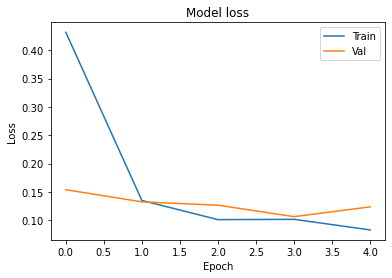

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

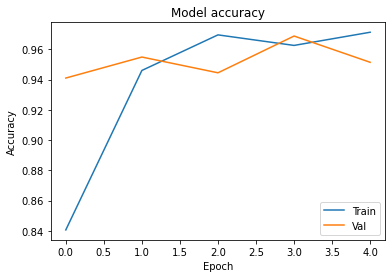

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Making Prediction

[1. 0. 0.]
[5.5482525e-09 0.0000000e+00 1.0000000e+00]
[1.000000e+00 0.000000e+00 2.284489e-28]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[7.157304e-20 0.000000e+00 1.000000e+00]
[1.0000000e+00 0.0000000e+00 8.3957615e-31]
[1. 0. 0.]
[1.000000e+00 0.000000e+00 3.932354e-18]
[1. 0. 0.]
[2.2647393e-14 0.0000000e+00 1.0000000e+00]
[1.0000000e+00 4.3292336e-20 0.0000000e+00]
[1. 0. 0.]
[1.000000e+00 0.000000e+00 8.728519e-37]
[1. 0. 0.]
[1.0000000e+00 0.0000000e+00 3.2796611e-38]
[1. 0. 0.]
[1.0000000e+00 0.0000000e+00 1.1264814e-22]


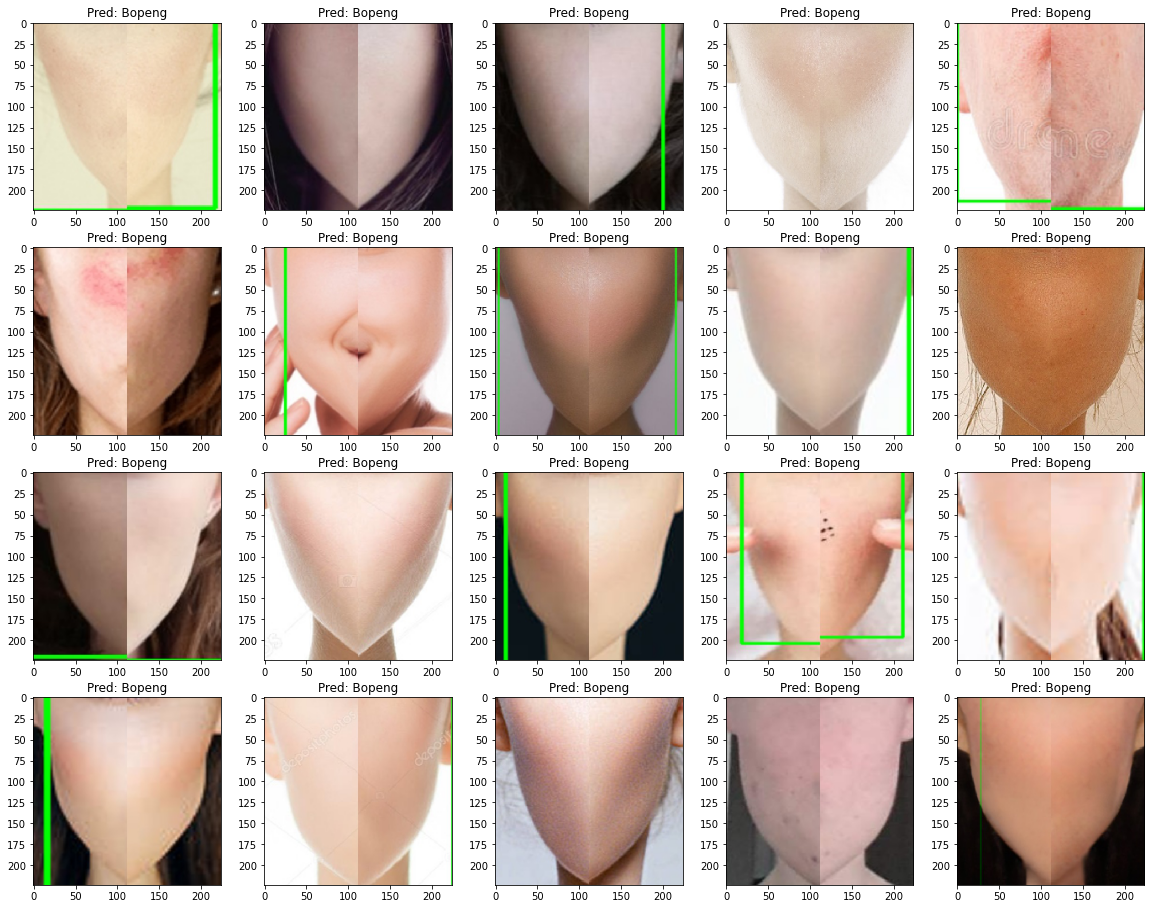

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

m = 1
columns = 5
rows = 5
directory = 'image-test-cropped/test-model-2/'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        print(classes[0])
        if classes[0,0]!=0:
            pred_labels = 'Bopeng'
        elif classes[0,1]!=0:
            pred_labels = 'Jerawat'
        elif classes[0,2]!=0:
            pred_labels = 'Komedo'
        else:
            pred_labels = 'Pori-pori'

        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.title("Pred: " + pred_labels)
        m += 1

In [26]:
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred, 0)

In [27]:
y_pred

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1

In [28]:
y_pred_labels = []

for value in range(len(y_pred)):
    if y_pred[value, 0] != 0:
        y_pred_labels.append(0)
    elif y_pred[value, 1] != 0:
        y_pred_labels.append(1)
    else:
        y_pred_labels.append(2)

y_pred_labels

[1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 1,


In [29]:
y_test.replace(['bopeng', 'jerawat', 'normal'], [0, 1, 2], inplace=True)
y_test

1324    2
205     0
755     1
1085    2
540     1
       ..
945     1
1123    2
1266    2
589     1
812     1
Name: tag, Length: 288, dtype: int64

In [30]:
categorical = ['bopeng', 'jerawat', 'normal']
classification_metrics = classification_report(y_pred_labels, y_test, target_names=categorical)
print(classification_metrics)

              precision    recall  f1-score   support

      bopeng       0.36      0.33      0.35       106
     jerawat       0.22      0.25      0.23        85
      normal       0.27      0.27      0.27        97

    accuracy                           0.28       288
   macro avg       0.28      0.28      0.28       288
weighted avg       0.29      0.28      0.29       288



In [31]:
cf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_df = pd.DataFrame(
    cf_matrix,
    index=["Bopeng", "Jerawat", "Normal"],
    columns=["Bopeng", "Jerawat", "Normal"]
)

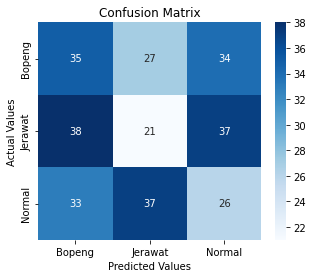

In [32]:
import seaborn as sns

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Save the Model

In [33]:
# MODEL_BASE_PATH = "model"
# PROJECT_NAME = "ausion_project"
# SAVE_MODEL_NAME = "ausion.h5"
# save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
# if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
#     os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

# print("Saving Model At {}...".format(save_model_path))
# model.save(save_model_path)
